## Анализ пользователей Stack Overflow

### Постановка задачи

В нашем распоряжении имеется база данных StackOverflow — сервиса вопросов и ответов о программировании.

**Задача** — проанализировать данные о пользовательской активности в помощью SQL-запросов, найти интересные инсайты и сделать выводы.

### Описание данных

**Таблица `badges`**

Хранит информацию о значках, которые присуждаются за разные достижения. Например, пользователь, правильно ответивший на большое количество вопросов про PostgreSQL, может получить значок postgresql. 

* `id` — идентификатор значка, первичный ключ таблицы
* `name` — название значка
* `user_id` — идентификатор пользователя, которому присвоили значок, внешний ключ, отсылающий к таблице `users`
* `creation_date` — дата присвоения значка

**Таблица `post_types`**

Содержит информацию о типе постов. Их может быть два:

* `id` — идентификатор поста, первичный ключ таблицы
* `type` — тип поста

**Таблица `posts`**

Содержит информацию о постах.

* `id` — идентификатор поста, первичный ключ таблицы
* `title` — заголовок поста
* `creation_date` — дата создания поста
* `favorites_count` — число, которое показывает, сколько раз пост добавили в «Закладки»
* `last_activity_date` — дата последнего действия в посте, например комментария
* `last_edit_date` — дата последнего изменения поста
* `user_id` — идентификатор пользователя, который создал пост, внешний ключ к таблице `users`
* `parent_id` — если пост написали в ответ на другую публикацию, в это поле попадёт идентификатор поста с вопросом
* `post_type_id` — идентификатор типа поста, внешний ключ к таблице `post_types`
* `score` — количество очков, которое набрал пост
* `views_count` — количество просмотров

**Таблица `users`**

Содержит информацию о пользователях.

* `id` — идентификатор пользователя, первичный ключ таблицы
* `creation_date` — дата регистрации пользователя
* `display_name` — имя пользователя
* `last_access_date` — дата последнего входа
* `location` — местоположение
* `reputation` — очки репутации, которые получают за хорошие вопросы и полезные ответы
* `views` — число просмотров профиля пользователя

**Таблица `vote_types`**

Содержит информацию о типах голосов. Голос — это метка, которую пользователи ставят посту. Типов бывает несколько: 

* `UpMod` — такую отметку получают посты с вопросами или ответами, которые пользователи посчитали уместными и полезными.
* `DownMod` — такую отметку получают посты, которые показались пользователям наименее полезными.
* `Close` — такую метку ставят опытные пользователи сервиса, если заданный вопрос нужно доработать или он вообще не подходит для платформы.
* `Offensive` — такую метку могут поставить, если пользователь ответил на вопрос в грубой и оскорбительной манере, например, указав на неопытность автора поста.
* `Spam` — такую метку ставят в случае, если пост пользователя выглядит откровенной рекламой.

Структура таблицы:

* `id` — идентификатор типа голоса, первичный ключ
* `name` — название метки

**Таблица `votes`**

Содержит информацию о голосах за посты. 

* `id` — идентификатор голоса, первичный ключ
* `post_id` — идентификатор поста, внешний ключ к таблице `posts`
* `user_id` — идентификатор пользователя, который поставил посту голос, внешний ключ к таблице `users`
* `bounty_amount` — сумма вознаграждения, которое назначают, чтобы привлечь внимание к посту
* `vote_type_id` — идентификатор типа голоса, внешний ключ к таблице `vote_types`
* `creation_date` — дата назначения голоса






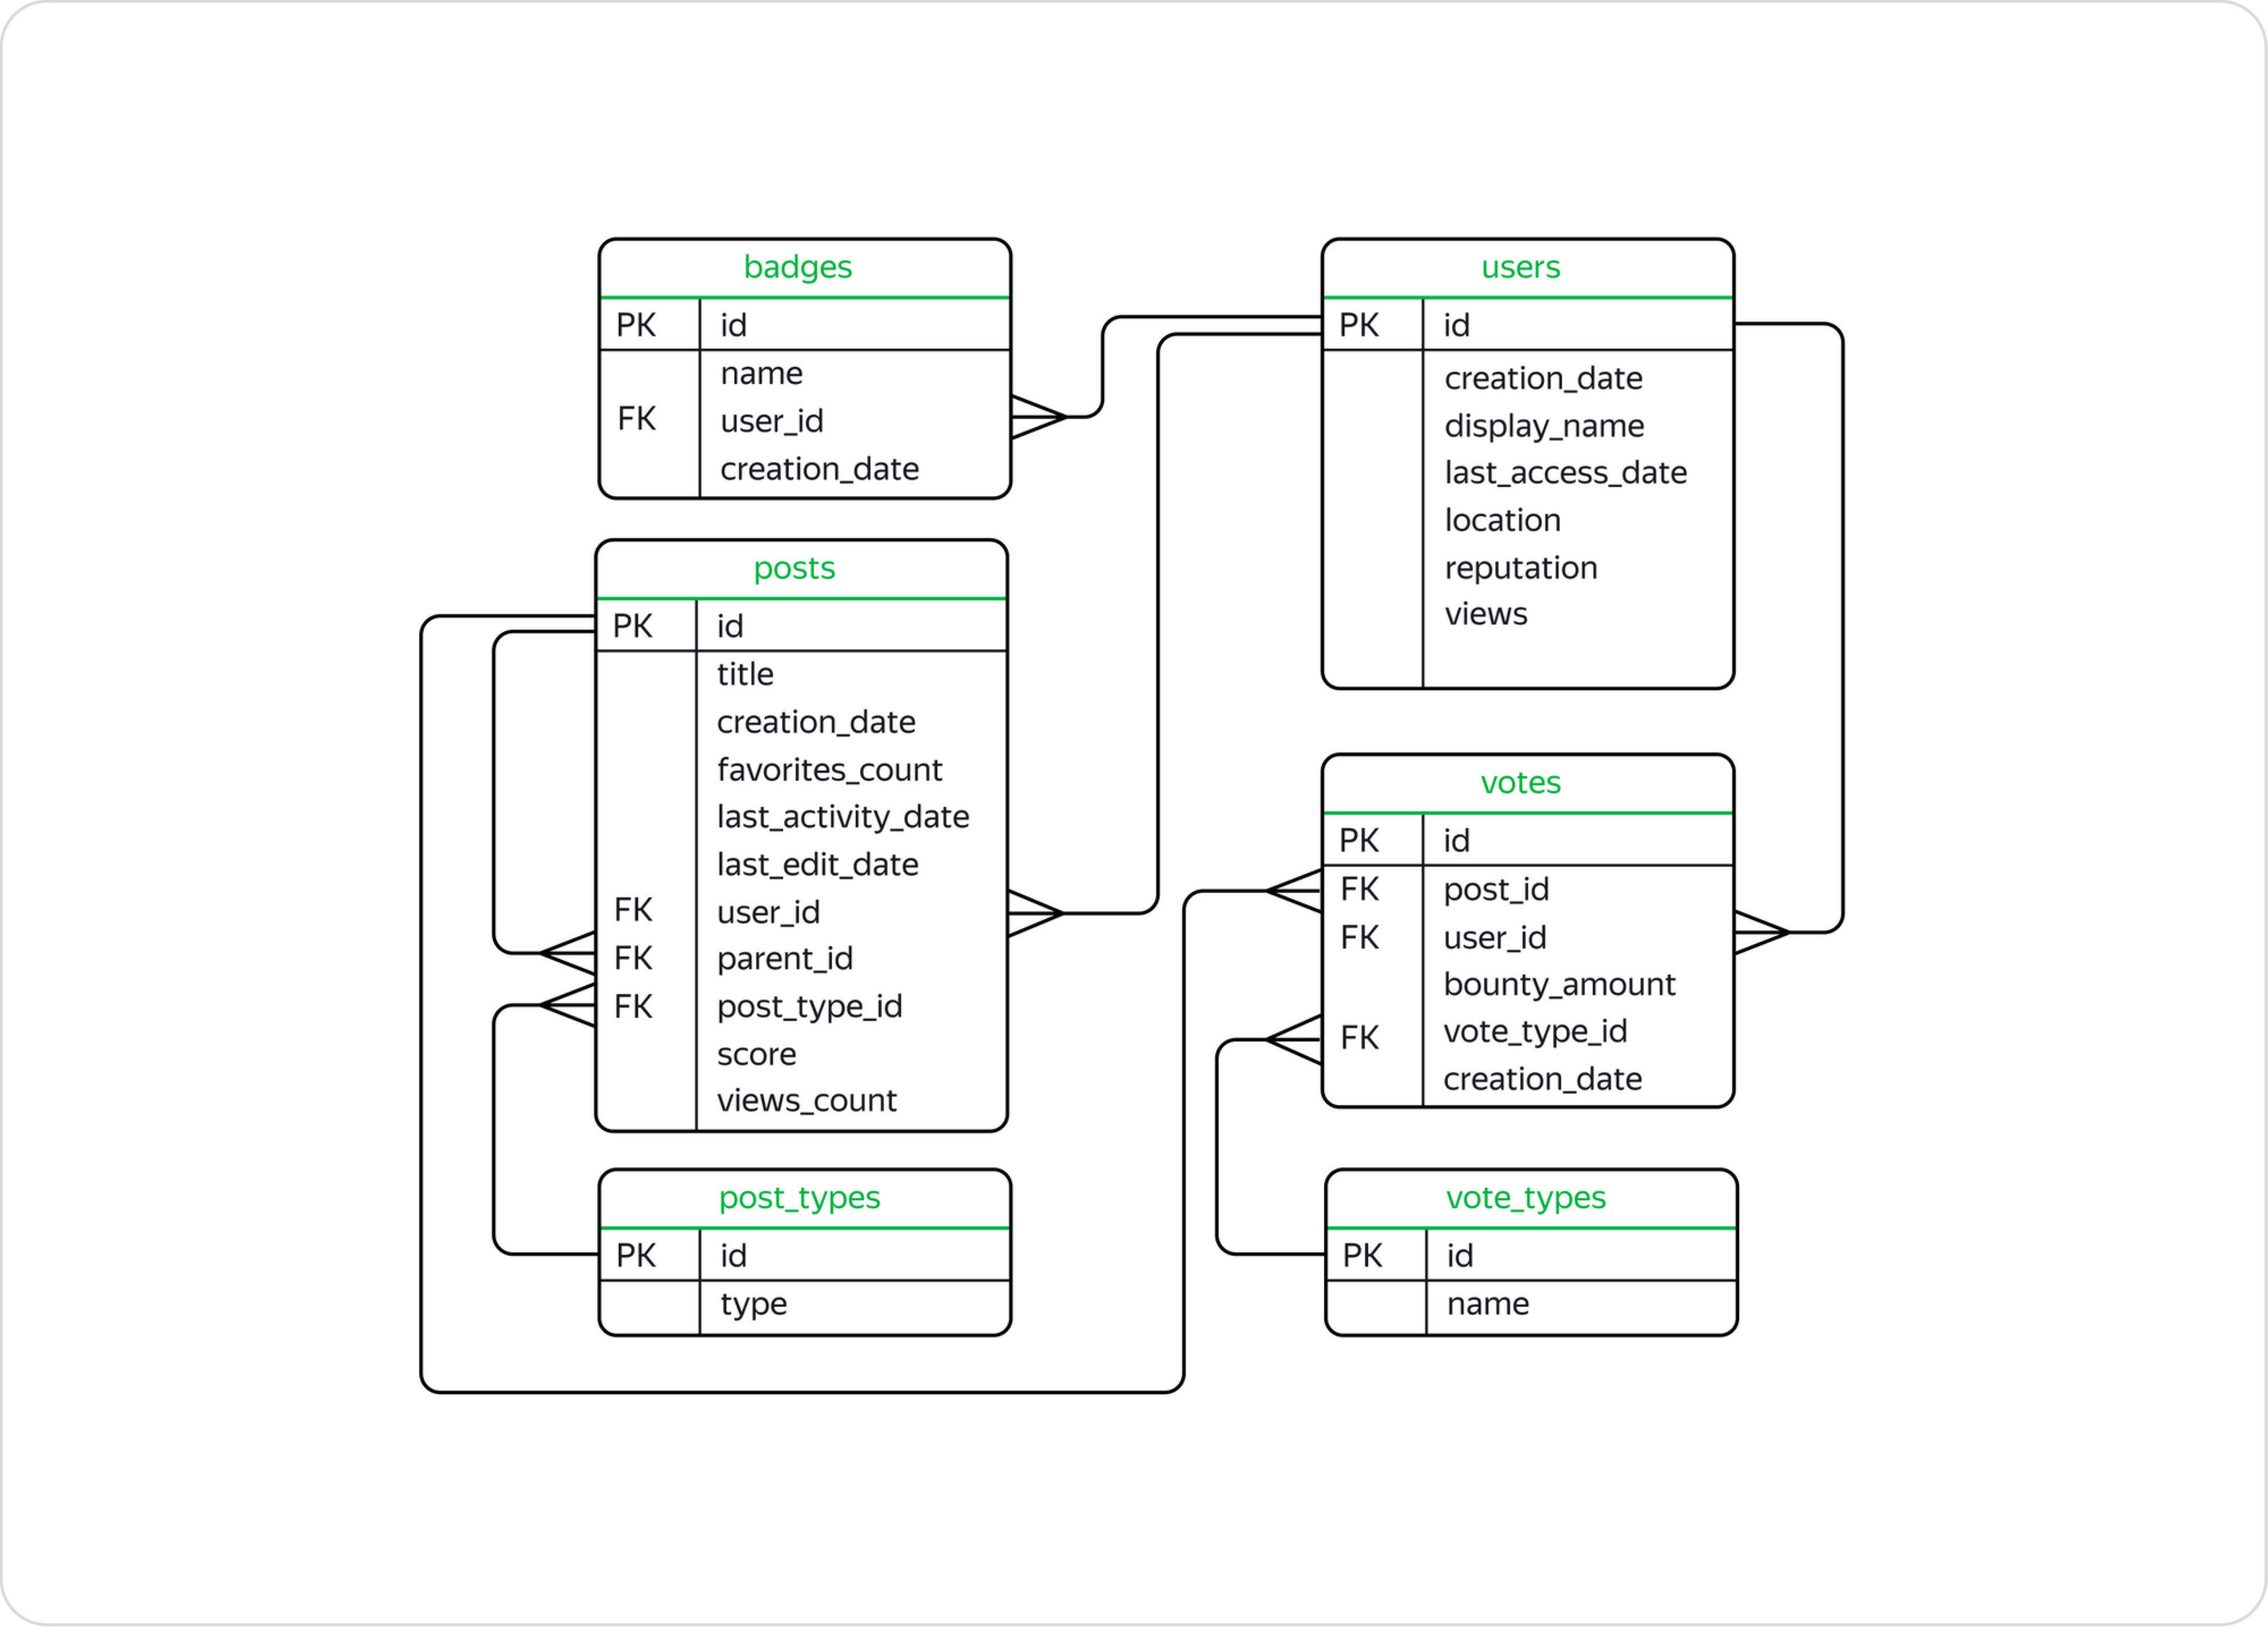

### Импортирование библиотек

In [1]:
# Импортирование библиотек
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns

### Подключение к базе данных

In [2]:
# Запишем параметры подлючения к БД в словарь
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

# Сформируем строку запроса к БД из словаря db_config
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

# Создание подключения
engine = create_engine(connection_string) 

### Анализ данных

Выведем общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируем по убыванию общего количества просмотров.

In [3]:
# Текст SQL-запроса
query = '''

SELECT date_trunc('month', creation_date) AS month,
       SUM (views_count) AS total_views
FROM stackoverflow.posts
GROUP BY date_trunc('month', creation_date)
ORDER BY total_views DESC

'''

# Запишем результат запроса в датафрейм 
df = pd.read_sql_query(query, con=engine)

# Выведем результат
df

,month,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Количество просмотров постов в разные месяцы отличается, наибольшее количество просмотров в сентябре и октябре. Можно предположить, что это связано с началом учебного года: студенты IT-специальностей активнее просматривают посты в учебное время.

Теперь выведем имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не будем учитывать. Для каждого имени пользователя выведем количество уникальных значений `user_id`. Отсортируем результат по полю с именами в лексикографическом порядке.

In [4]:
# Текст SQL-запроса
query = '''

SELECT u.display_name,
       COUNT (DISTINCT u.id) AS user_id_count
FROM stackoverflow.users AS u
JOIN stackoverflow.posts AS p ON u.id = p.user_id
JOIN stackoverflow.post_types AS pt ON pt.id = p.post_type_id
WHERE p.creation_date BETWEEN u.creation_date AND u.creation_date + interval '1 month'
  AND pt.type = 'Answer'
GROUP BY display_name
HAVING COUNT (DISTINCT p.id) > 100

'''

# Запишем результат запроса в датафрейм 
df = pd.read_sql_query(query, con=engine)

# Выведем результат
df

,display_name,user_id_count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
71,leppie,1
72,lomaxx,1
73,mattlant,1
74,paxdiablo,1


В таблице есть имена, на которые приходится несколько идентификаторов пользователей. То есть, при группировке данных по имени пользователя в строку попадает данные нескольких пользователей. Следовательно, для анализа данных имя пользователя — не лучший параметр для группировки, лучше выбирать уникальный идентификатор.

Выведем количество постов за 2008 год по месяцам. Отберем посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируем таблицу по значению месяца по убыванию.

In [5]:
# Текст SQL-запроса
query = '''

SELECT date_trunc ('month', creation_date)::date AS month,
       COUNT (id) posts_num
FROM stackoverflow.posts
WHERE user_id in
    (SELECT DISTINCT u.id
     FROM stackoverflow.users AS u
     JOIN stackoverflow.posts AS p ON u.id = p.user_id
     WHERE date_trunc ('month', u.creation_date) = '2008-09-01'
       AND date_trunc ('month', p.creation_date) = '2008-12-01')
  AND date_trunc ('year', creation_date) = '2008-01-01'
GROUP BY date_trunc ('month', creation_date)
ORDER BY date_trunc ('month', creation_date) DESC

'''

# Запишем результат запроса в датафрейм 
df = pd.read_sql_query(query, con=engine)

# Выведем результат
df

,month,posts_num
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


В итоговую таблицу попали данные за август, чего быть не должно, так как данные отфильтрованы по пользователям, которые зарегистрировались в сентябре. Вероятно, в данных есть ошибка: посты, написанные в августе, по ошибке были присвоены пользователям, которые зарегистрировались позднее. 

Теперь, используя данные о постах, выведем несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице отсортируем по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [6]:
# Текст SQL-запроса
query = '''

SELECT user_id,
       creation_date,
       views_count,
       SUM (views_count) OVER (PARTITION BY user_id ORDER BY creation_date)
FROM stackoverflow.posts
ORDER BY user_id

'''

# Запишем результат запроса в датафрейм 
df = pd.read_sql_query(query, con=engine)

# Выведем результат
df

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


Найдем среднее количество постов пользователей в день за август 2008 года. Отберем данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не будем учитывать. 

Отсортируем результат по возрастанию среднего количества постов.

In [7]:
# Текст SQL-запроса
query = '''

WITH users_posts AS
  (SELECT user_id,
          COUNT (*) AS posts_num
   FROM stackoverflow.posts
   WHERE date_trunc('month', creation_date) = '2008-08-01'
   GROUP BY 1
   HAVING count(*) > 120),
     august_days AS
  (SELECT user_id,
          COUNT (DISTINCT date_trunc('day', creation_date)) AS days
   FROM stackoverflow.posts
   WHERE user_id in
       (SELECT user_id
        FROM users_posts)
     AND date_trunc('month', creation_date) = '2008-08-01'
   GROUP BY 1)
   
SELECT up.user_id,
       up.posts_num::numeric / ad.days AS avg_daily
FROM august_days AS ad
JOIN users_posts AS up ON ad.user_id = up.user_id
ORDER BY up.posts_num::numeric / ad.days

'''

# Запишем результат запроса в датафрейм 
df = pd.read_sql_query(query, con=engine)

# Выведем результат
df

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


Узнаем, сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой. Для каждого пользователя отберем дни, в которые он или она опубликовали хотя бы один пост.

In [8]:
# Текст SQL-запроса
query = '''

WITH temp_table AS
  (SELECT user_id,
          COUNT (DISTINCT date_trunc ('day', creation_date)) AS active_days
   FROM stackoverflow.posts
   WHERE creation_date BETWEEN '2008-12-01' AND '2008-12-08'
   GROUP BY user_id)
   
SELECT ROUND (AVG (active_days)) AS result
FROM temp_table

'''

# Запишем результат запроса в датафрейм 
df = pd.read_sql_query(query, con=engine)

# Выведем результат
df

,result
0,2.0


В период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой в среднем 2 дня.

Теперь выведем историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируем вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавим в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажем `NULL`.


In [9]:
# напишите запрос
query = '''

WITH temp_table AS
  (SELECT user_id,
          creation_date,
          lag (date_trunc('month', creation_date), 2, NULL) OVER (PARTITION BY user_id
                                                                  ORDER BY creation_date) AS second_last_month
   FROM stackoverflow.posts
   ORDER BY user_id)
   
SELECT user_id,
       creation_date,
       to_char(second_last_month,'Month')
FROM temp_table

'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)
df

,user_id,creation_date,to_char
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


Рассчитаем аналог Retention Rate по месяцам для пользователей StackOverflow. Объединим пользователей в когорты по месяцу их первого поста. Возвращение определим по наличию поста в текущем месяце. 

In [10]:
# Текст SQL-запроса
query = '''

WITH temp_table AS
  (SELECT user_id,
          MIN (date_trunc ('month', creation_date)) AS cohort_month
   FROM stackoverflow.posts
   GROUP BY user_id
   ORDER BY user_id),
   
     profiles AS
  (SELECT *,
          COUNT (user_id) OVER (PARTITION BY cohort_month) AS cohort_size
   FROM temp_table
   ORDER BY cohort_month),
   
     sessions AS
  (SELECT user_id,
          date_trunc('month', creation_date) AS activity_month
   FROM stackoverflow.posts
   GROUP BY 1,
            2)
            
SELECT p.cohort_month,
       s.activity_month,
       COUNT (p.user_id) AS usеrs_cnt,
       p.cohort_size,
       round (COUNT (p.user_id) * 100.0 / p.cohort_size, 2) AS retention_rate
FROM profiles AS p
JOIN sessions AS s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4

'''

# Запишем результат запроса в датафрейм 
df = pd.read_sql_query(query, con=engine)

# Выведем результат
df

,cohort_month,activity_month,usеrs_cnt,cohort_size,retention_rate
0,2008-07-01,2008-10-01,2,3,66.67
1,2008-10-01,2008-12-01,1221,3629,33.65
2,2008-12-01,2008-12-01,2536,2536,100.00
3,2008-08-01,2008-08-01,2151,2151,100.00
4,2008-08-01,2008-12-01,894,2151,41.56
5,2008-09-01,2008-11-01,2966,7678,38.63
6,2008-07-01,2008-07-01,3,3,100.00
7,2008-09-01,2008-10-01,4132,7678,53.82
8,2008-10-01,2008-11-01,1640,3629,45.19
9,2008-09-01,2008-12-01,2500,7678,32.56


Построим тепловую карту Retention Rate, выявим аномалии и необычные явления.

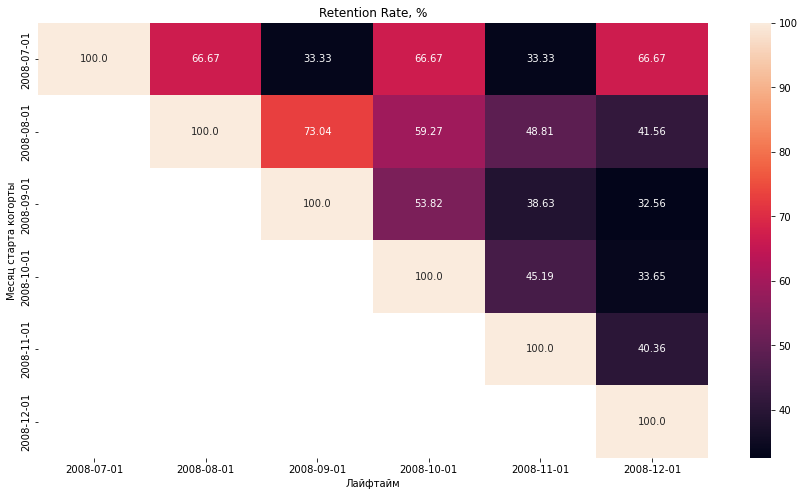

In [11]:
# создаём сводную таблицу с результатами
retention = df.pivot('cohort_month', 'activity_month', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(15, 8)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Retention Rate, %') # название графика
plt.xlabel('Лайфтайм')
plt.ylabel('Месяц старта когорты')


plt.show()

У июльской когорты странные результаты: показатели Retention Rate "скачут" от месяца к месяцу, хотя эта метрика должна уменьшаться, как в остальных когортах. Такая аномалия связана с размером когорты: июльская когорта состоит всего из трех пользователей, данные по ней не репрезентативны и не должны учитываться при анализе.

В целом удержание пользователей платформы падает: Retention Rate первого лайфтайма августовской когорты составляет 73%, в то время как для ноябрьской корогорты это значение равно 40%. Такая картина характерна для всех лайфтаймов.

Падение удержания может быть связаным с большим количеством причин: качеством привлекаемых пользователей, изменениями в интерфейсе платформы, сезонностью и прочими факторами.

Теперь посмотрим, на сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года. Отобразим таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлим значение процента до двух знаков после запятой.


In [12]:
# Текст SQL-запроса
query = '''

WITH temp_table AS
  (SELECT EXTRACT (MONTH
                   FROM creation_date) AS creation_month,
                  COUNT (*) AS posts_count
   FROM stackoverflow.posts
   WHERE creation_date BETWEEN '2008-09-01' AND '2009-01-01'
   GROUP BY EXTRACT (MONTH
                     FROM creation_date)
   ORDER BY EXTRACT (MONTH
                     FROM creation_date))
SELECT *,
       round ((posts_count * 100.0 / lag(posts_count) OVER ()) - 100, 2) AS percentage
FROM temp_table

'''

# Запишем результат запроса в датафрейм 
df = pd.read_sql_query(query, con=engine)

# Выведем результат
df

,creation_month,posts_count,percentage
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


Количество постов падает из месяца в месяц, однако, в декабре темпы падения уменьшились — падение составило 5% против 26% в ноябре.

Построим круговую диаграмму с количеством постов по месяцам.

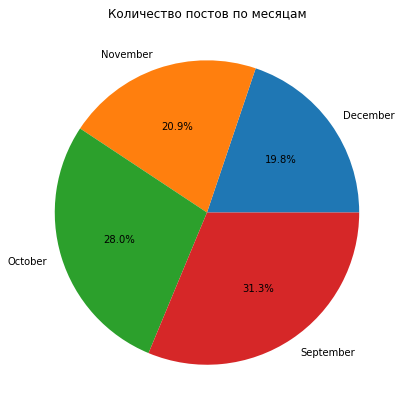

In [13]:
# Построим круговую диаграмму с количеством постов по месяцам

month_names = {9: 'September',
               10: 'October',
               11: 'November',
               12: 'December'}

df['creation_month'] = df['creation_month'].map(month_names)

df.groupby('creation_month')['posts_count'].sum().plot(kind = 'pie',
                                                       y='posts_count',
                                                       figsize=(7,7),
                                                       title="Количество постов по месяцам",
                                                       autopct='%1.1f%%');
plt.ylabel('');

В сентябре было написано больше всего постов - почти треть от общего количества за сентябрь-декабрь. В декабре постов меньше всего, менее 20%.

Выгрузим данные активности пользователя, который опубликовал больше всего постов за всё время. Выведем данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

In [14]:
# Текст SQL-запроса
query = '''

WITH tt AS
  (SELECT user_id,
          COUNT (id) AS posts_num
   FROM stackoverflow.posts
   GROUP BY user_id
   ORDER BY posts_num DESC)
SELECT EXTRACT (WEEK
                FROM creation_date) AS week_creation,
       MAX (creation_date) AS max_creation_date
FROM stackoverflow.posts
WHERE user_id =
    (SELECT user_id
     FROM tt
     WHERE posts_num =
         (SELECT MAX (posts_num)
          FROM tt))
  AND date_trunc('month', creation_date) = '2008-10-01'
GROUP BY EXTRACT (WEEK
                  FROM creation_date)

'''

# Запишем результат запроса в датафрейм 
df = pd.read_sql_query(query, con=engine)

# Выведем результат
df

,week_creation,max_creation_date
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01


## Выводы

* Количество просмотров постов в разные месяцы отличается, наибольшее количество просмотров было в сентябре и октябре. Можно предположить, что это связано с началом учебного года: студенты IT-специальностей активнее просматривают посты в учебное время.
* Вероятно, в базе данных есть ошибка: посты, написанные в августе, по ошибке были присвоены пользователям, которые зарегистрировались позднее. 
* В период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой в среднем 2 дня.
* Удержание пользователей платформы падает: Retention Rate первого лайфтайма августовской когорты составляет 73%, в то время как для ноябрьской корогорты это значение равно 40%. Такая картина характерна для всех лайфтаймов. Падение удержания может быть связаным с большим количеством причин: качеством привлекаемых пользователей, изменениями в интерфейсе платформы, сезонностью и прочими факторами.
* В сентябре было написано больше всего постов - почти треть от общего количества за сентябрь-декабрь. В декабре постов меньше всего, менее 20%. Количество постов падает из месяца в месяц, однако, в декабре темпы падения уменьшились — падение составило 5% против 26% в ноябре.